In [14]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# V2
## Szenario-basierte Berechnungen für Energieverbrauchs- und Erzeugungsentwicklung bis 2030

In diesem Notebook führen wir Szenario-basierte Berechnungen für die Entwicklung von Energieverbrauch und -produktion durch.

## Importieren der Bibliotheken

Wir beginnen mit dem Importieren der erforderlichen Bibliotheken, einschließlich `pandas` für die Datenverarbeitung und `matplotlib` für die Visualisierung.

In [15]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from pathlib import Path
from datetime import datetime

### selbstgeschriebene Utils
Für bessere Übersicht wurden Funktionen in Python-Skripte ausgelagert und werden hier importiert, damit sie später im Code aufgerufen werden können.

In [16]:
# eigene Utils

from utils.temperature import temperatureRegion
from utils.addTimeInformation import addTimeInformation
from utils.combineDataFrames import combineDataFrames
from utils.extraploation_class import Extrapolation
from utils.plotCalendarHeatmap import plotCalendarHeatmap
from utils.read_CSV import *
from utils.calcDifference_storage_flexpowerplant import differenceBetweenDataframes
from utils.calculateConsumption import calculateConsumption, getConsumptionYear, calculateConsumption_lastprofile
from utils.plotResidualDiagram import plotResidualDiagram
from utils.plotWeekDiagram import plotWeekDiagramm, create_week_comparison
from utils.determinePerformanceSzenarios import determinePerformanceSzenarios
from utils.performance_factors import performance_factors
from utils.addTimePerformance import addTimePerformance
from utils.dunkelflautePerformanceFactor import dunkelflautePerformanceFactor
from utils.load_profile_heat_pump import heatpump_Region
from utils.calculate_future_generation import calculate_future_generation
from utils.cleanse_dataframes import cleanse_dataframes



## Szenarien-Definition
Das Programm rechnet mit Variablen für `Verbrauchsentwicklung`, `PV-Leistung`, `Wind-Leistung (Onshore)` und `Windleistung (Onshore)`

Zu Beginn wird festgelegt, welches Szenario gerechnet werden soll, je nachdem werden die eben genannten Variablen festgesetzt. Die Werte für die Szenarien wurden aus den Big5-Studien ermittelt.

In [17]:
# Faktoren, Variablen
from szenarioDefinition.szenario import *

## CSV einlesen (Erzeugung)
Wir lesen die SMARD-Daten für realisierte Erzeugung (2015-2023).
Ist das abgeschlossen, werden die Daten ab 2024 bis 2030 extrapoliert und in einem Dataframe gespeichert, dass Daten für alle Jahre enthält.

In [18]:
#alle Daten ab 2015 einlesen
directory_yearly_generation = getData("Generation")

Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


## PerformanceFaktoren(2015-2023):

Erstellung von Performance Faktoren um Wetterabhängigkeit zu implementiern und erzeugte Energie anhand der Installierten Leistung abzuleiten


In [19]:

directory_yearly_installed = getData("Installed")
directory_yearly_performance = performance_factors(directory_yearly_generation, directory_yearly_installed)
directory_szenarios=determinePerformanceSzenarios(directory_yearly_performance)
directory_szenarios["BestCase"].to_csv("CSV/Performance_factors/cases/BestCase.csv")
directory_szenarios["WorstCase"].to_csv("CSV/Performance_factors/cases/WorstCase.csv")
directory_szenarios["BestCase"]= addTimePerformance(directory_szenarios["BestCase"], 2030)
dunkelflautePerformanceFactor(directory_yearly_performance)


Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


/Users/private/Desktop/Projects/Klimaneutral-20245/utils/determinePerformanceSzenarios.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meanPerformanceFactors = pd.concat([meanPerformanceFactors, pd.DataFrame([{"Jahr": year, "Photovoltaik": meanPV, "Wind Onshore": meanOnshore, "Wind Offshore": meanOffshore}])], ignore_index=True)


Es lag eine Dunkelflaute vom 2015-01-18 14:45:00 bis zum 2015-01-21 14:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2021-01-06 23:45:00 bis zum 2021-01-09 23:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2022-11-29 01:30:00 bis zum 2022-12-02 01:15:00 vor Anzahl Viertelstunden: 288


## Erzeugung hochrechnen

In [20]:
directory_yearly_generation.update(calculate_future_generation("best_case", "best_case", "best_case", directory_szenarios["BestCase"], directory_yearly_generation[2023]))


## Erzeugung 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch die Gesamtsumme der EE-Erzeugung enthält (15-Min-AUflösung).

In [21]:
# Lade die Daten für das Jahr 2030
df_2030 = directory_yearly_generation.get(2030)

# Überprüfe, ob die Spalten vorhanden sind
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']
if all(column in df_2030.columns for column in required_columns):
    # Berechne die Summe der gewünschten Spalten für jede 15-Minuten-Periode
    df_2030['Gesamterzeugung_EE'] = df_2030[required_columns].sum(axis=1)
    
    # Speichere die Ergebnisse in production_2030
    production_2030 = df_2030[['Datum', 'Gesamterzeugung_EE']]
    
    #print(production_2030)
else:
    print("Eine oder mehrere der erforderlichen Spalten fehlen im DataFrame für 2030.")

# Verbrauch 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch den Gesamtverbrauch enthält (15-Min-AUflösung).

## Lastprofile Wärmepumpe 2023-2030

In [22]:
#directory_heatpump_consumption = load_profile_heatpump(IST_installierte_waermepumpen,SOLL_installierte_waermepumpen,2024,2030)
#directory_heatpump_consumption = lastprofil_heatpump(IST_installierte_waermepumpen,SOLL_installierte_waermepumpen,2024,2030,"AverageCase")
#print(directory_heatpump_consumption[2030])
#directory_heatpump_consumption[2024].to_csv("Heatpump2024.csv")
#directory_temperature = temperaturetest("BestCase")
directory_heatpump = heatpump_Region(IST_installierte_waermepumpen,SOLL_installierte_waermepumpen, 2024, 2030, "BestCase")


/Users/private/Desktop/Projects/Klimaneutral-20245/utils/load_profile_heat_pump.py:123: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  combined_population = float(df_population.sum(axis=1)) # Summe der Bevölkerungszahlen für Deutschland


## Lastprofile eAutos

In [24]:
lastprofile_dict = {}

# Anzahl eAutos verändert sich jedes Jahr, deshalb auch neue Lastprofile für jedes Jahr bis 2030
# 2023 1.4Mio eAutos
# jedes Jahr 150 000 mehr eAutos
for year in range(2023, 2031):
    lastprofil_workday = pd.read_csv(f'CSV/Lastprofile/eMobilitaet/{year}/lastprofil_Arbeitstag.csv', delimiter= ',', decimal='.', dayfirst ="True") #, parse_dates=[[0,1]]
    lastprofil_saturday = pd.read_csv(f'CSV/Lastprofile/eMobilitaet/{year}/lastprofil_Samstag.csv', delimiter= ',', decimal='.', dayfirst ="True") #, parse_dates=[[0,1]]
    lastprofil_sunday = pd.read_csv(f'CSV/Lastprofile/eMobilitaet/{year}/lastprofil_Sonntag_Feiertage.csv', delimiter= ',', decimal='.', dayfirst ="True") #, parse_dates=[[0,1]]

    lastprofile_dict[year] = {
        'workday': lastprofil_workday,
        'saturday': lastprofil_saturday,
        'sunday': lastprofil_sunday
    }


#print(lastprofile_dict[2023]['workday'])

print(directory_heatpump.head())



# zu Hochrechnung übergeben wir die allgemeien Wachstumsrate pro Jahr, die Lastprofile EAutos und die Lastprofile für alle Jahre der Wärmepumpen
consumption_existing_years_lastprofile = calculateConsumption_lastprofile(consumption_development_per_year, lastprofile_dict, directory_heatpump)

     Uhrzeit  Relative Bedarf  Normierter Bedarf (Prozent)  Anzahl Autos  \
0   00:00:00         0.248823                     0.007183  10055.717811   
1   00:15:00         0.216914                     0.006262   8766.178877   
2   00:30:00         0.183494                     0.005297   7415.554909   
3   00:45:00         0.151384                     0.004370   6117.896587   
4   01:00:00         0.119929                     0.003462   4846.721087   
..       ...              ...                          ...           ...   
91  22:45:00         0.490830                     0.014169  19835.998854   
92  23:00:00         0.473373                     0.013665  19130.498462   
93  23:15:00         0.417236                     0.012044  16861.803283   
94  23:30:00         0.361098                     0.010424  14593.108129   
95  23:45:00         0.304960                     0.008803  12324.412976   

    Strombedarf (kWh)  
0        64356.593993  
1        56103.544816  
2        47459.

KeyError: 'Verbrauch'

## Verbrauch an sich extrapolieren

In [23]:
consumption_existing_years = calculateConsumption(consumption_development_per_year)
consumption_2030 = consumption_existing_years.get(2030)

Data für 2023 loaded succsessfully.


## Wochenvergleich zwischen Verbrauch und Verbrauch+Lastprofile

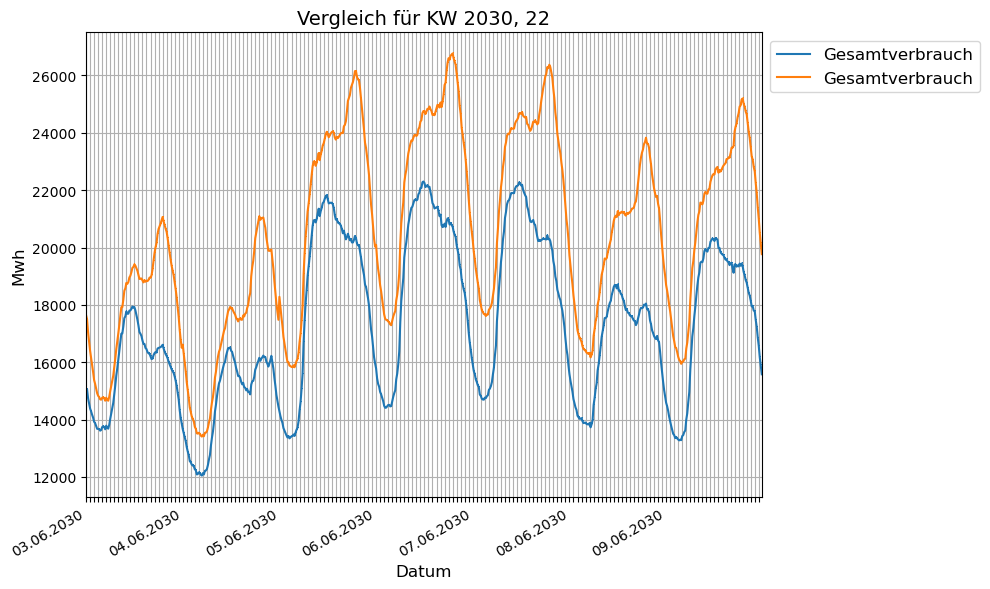

In [24]:
selected_week = '22'
selected_year = '2030'



def get_weekly_consumption(consumption_data, selected_year, selected_week):
    # Erstelle einen DataFrame aus dem Dictionary
    yearly_consumption = pd.DataFrame.from_dict(consumption_data.get(int(selected_year)))

    # Filtere die Daten für die angegebene Woche und das Jahr
    week_filtered_data_consumption = yearly_consumption[
        (yearly_consumption['Week'] == selected_week)
    ]

    # Erstelle einen DataFrame nur mit Datum und Gesamtverbrauch
    week_consumption_df = week_filtered_data_consumption[['Datum', 'Gesamtverbrauch']]
    week_consumption_df.loc[:, 'Datum'] = pd.to_datetime(week_consumption_df['Datum'])

    return week_consumption_df


# Verwende die Funktion für consumption_existing_years
week_consumption_df = get_weekly_consumption(consumption_existing_years, selected_year, selected_week)

# Verwende die Funktion für consumption_existing_years_lastprofile
week_consumption_df_lp = get_weekly_consumption(consumption_existing_years_lastprofile, selected_year, selected_week)

# didirectory_yearly_generation and consumption_existing_years are dicitionaries

create_week_comparison(selected_week, selected_year, week_consumption_df, week_consumption_df_lp, "vergleich_verbrauch_lastprofile")

# Differenz bilden

Wir bestimmen die Resiudallast als Differenz zwischen Verbrauch und Erzeugung für die 2030-Dataframes.
Damit können wir den Anteil nicht-EE-Energie bestimmen an der Gesamtenergieerzeugung, der Anteil soll abnehmen.

In [25]:
# Bereinigen der DataFrames von Schaltjahren oder Zeitumstellung
cleaned_consumption_2030, cleaned_production_2030 = cleanse_dataframes(consumption_2030, production_2030)


resdidual_df = differenceBetweenDataframes(cleaned_consumption_2030, cleaned_production_2030)

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/cleanse_dataframes.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Datum'] = pd.to_datetime(df2['Datum'], format='%Y-%m-%d %H:%M')


# Auswertung
Um die Daten besser zu verstehen, plotten wir verschiedene Diagramme in unterschiedlicher Auflösung (15min - jährlich) für verschiedene Kennzahlen.
- Heatmap für ein Jahr
- Summenhistogramm für ein Jahr
- Residuallast über die Jahre bis 2030
- Wochendiagramm für den Vergleich von Verbrauch und Erzeugung

## HeatMap

Für das Jahr 2030 plotten wir eine Heatmap: Grüne Flächen bedeuten eine gute Abdeckung des Verbrauchs durch EE-Energie, rote Flächen zeigen Defizite in der EE-Versorgung.

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/plotCalendarHeatmap.py:7: FutureWarning: The provided callable <function sum at 0x10a931b20> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  heatmap_data = df.pivot_table(index='Year Month', columns='Day', values=colName, aggfunc=np.sum)    # aggfunc=np.sum ->Werte summiert über den Tag!


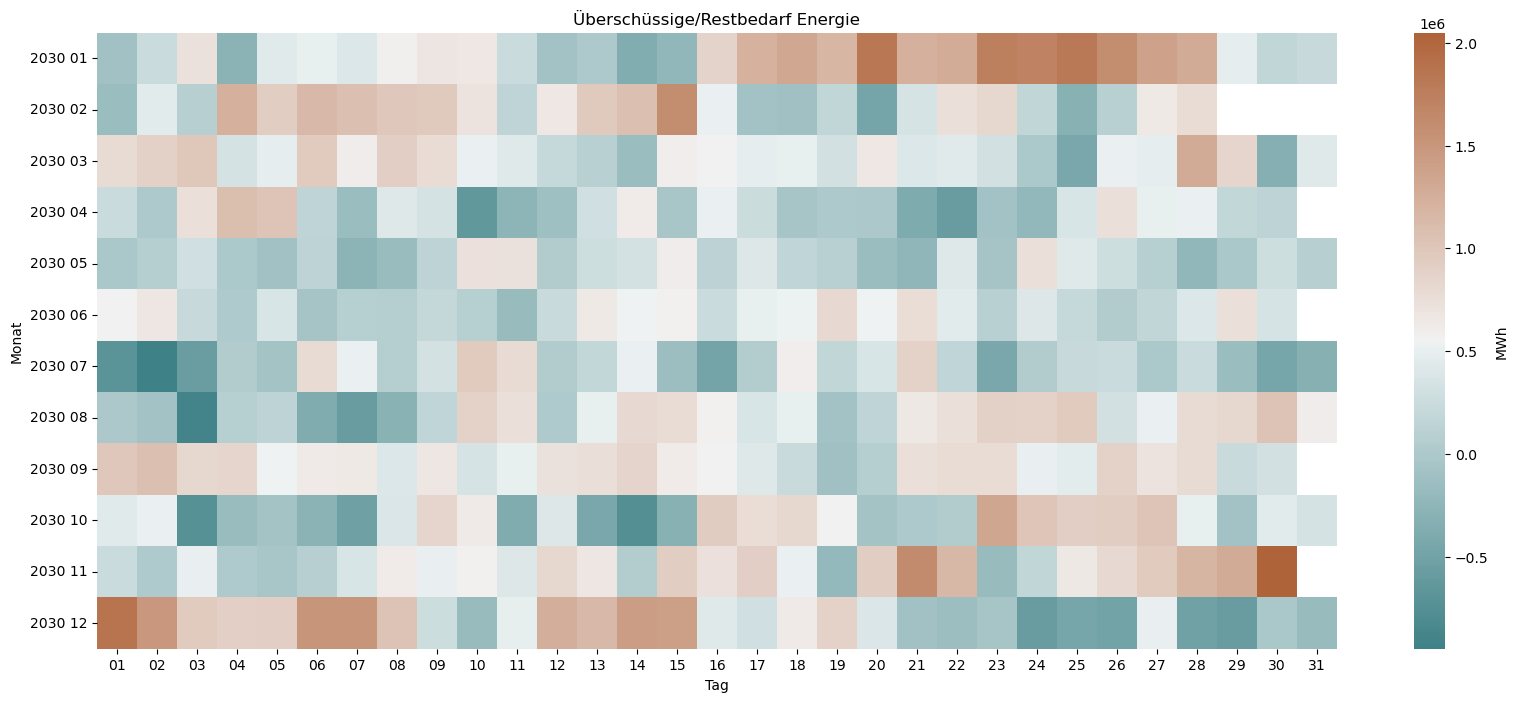

In [26]:
plotCalendarHeatmap(resdidual_df, "Überschüssige/Restbedarf Energie", "Differenz in MWh", linewidths = 0)

## Summenhistogramm
Zusätzlich wird ein Summendiagramm erstellt, das die Anzahl der zu 80% durch EE-Energie gedeckten 15-Minuten aufzeigt.

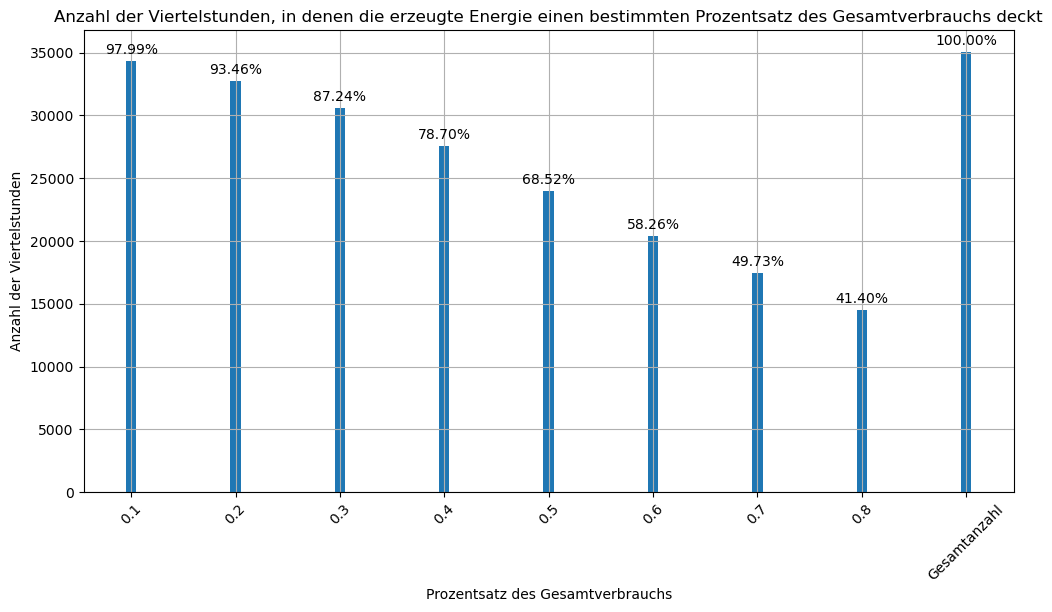

In [27]:

# Prozentsätze definieren
percentages = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

# Dictionary, um die Anzahl der Viertelstunden für jeden Prozentsatz zu speichern
coverage_counts = {percentage: 0 for percentage in percentages}

# Berechne die Deckung für jede Viertelstunde
for index, row in production_2030.iterrows():
    for percentage in percentages:
        if row['Gesamterzeugung_EE'] >= percentage * consumption_2030.loc[index, 'Gesamtverbrauch']:
            coverage_counts[percentage] += 1

# Füge die Gesamtanzahl der Viertelstunden hinzu
total_quarters = len(production_2030)
coverage_counts['Gesamtanzahl'] = total_quarters

# Erstelle ein Summenhistogramm
plt.figure(figsize=(12, 6))
# Convert keys to strings for consistent data types
coverage_counts_str_keys = {str(key): value for key, value in coverage_counts.items()}

bars = plt.bar(coverage_counts_str_keys.keys(), coverage_counts_str_keys.values(), width=0.10, align='center')

# Annotate bars with percentage of total quarters
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_quarters) * 100
    plt.annotate(f'{percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Prozentsatz des Gesamtverbrauchs')
plt.ylabel('Anzahl der Viertelstunden')
plt.title('Anzahl der Viertelstunden, in denen die erzeugte Energie einen bestimmten Prozentsatz des Gesamtverbrauchs deckt')
plt.xticks([str(key) for key in coverage_counts.keys()], rotation=45)
plt.grid(True)
plt.savefig('assets/plots/summenhistogramm.png')
plt.show()



## Diagramm für Residuallast (Differenz zw. EE-Erzeugung und Verbrauch)

**positive Differenz (Erzeugung > Verbrauch)**<br>
Hinweis auf eine Überschussproduktion, die EE-Erzeugung deckt den Verbrauch vollkommen und darüber hinaus. Der erzeugte Strom kann nicht vollständig verwendet werden (Exportmöglichkeit).

**negative Differenz (Erzeugung < Verbrauch)**<br>
Der Verbrauch ist höher als die EE-Erzeugung und kann also nicht abgedeckt werden. EE müssen ausgebaut werden.

**Trend**<br>
Die Differenz kann bei höherer Auflösung betrachtet evtl. schwanken -> saisonale Unterschiede in Produktionsmöglichkeiten für EE (bsp. im Winter weniger Sonne).
Ein positiver langfristiger Trend könnte auf eine erfolgreiche Integration erneuerbarer Energien hinweisen, während ein negativer langfristiger Trend auf Herausforderungen bei der Deckung des Energiebedarfs durch erneuerbare Energien hinweisen könnte.


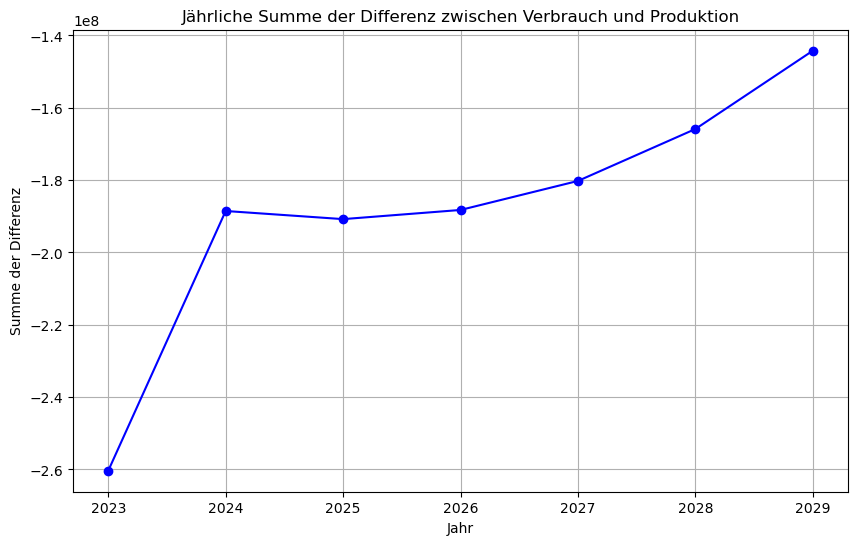

In [28]:
plotResidualDiagram(2023, 2030, directory_yearly_generation, consumption_existing_years)

## Wochendiagramm: Vergleich Verbrauch Erzeugung/Verbrauch, 15min

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/plotWeekDiagram.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = df['Datum'].dt.time
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/addTimeInformation.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

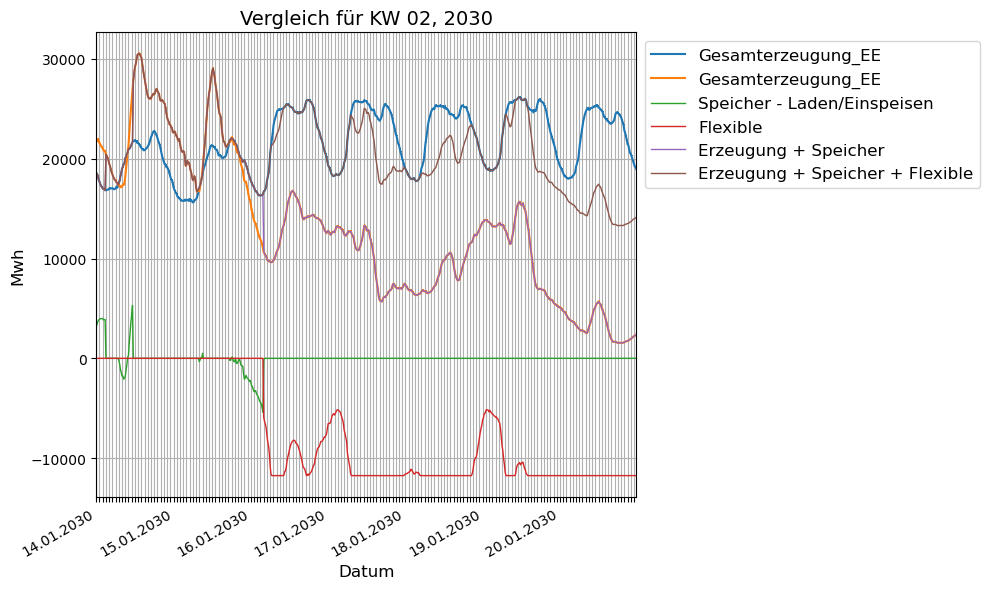

In [29]:
selected_week = '02'
selected_year = '2030'



# didirectory_yearly_generation and consumption_existing_years are dicitionaries

plotWeekDiagramm(selected_week, selected_year, consumption_existing_years, directory_yearly_generation,  "wochendiagramm_KW")

# CO2-Bilanz bilden

Wir untersuchen weiterhin die Residuallast - die hier verbleibenden MWh geben uns Auskunft über die verbleibenden CO2-Emissionen. Ist die Resiudalllast = 0, sind auch die Emissionen auf 0T gesunken.
Die Emissionen werden pro fossielem Energieträger (Kohle und Gas) berechnet. Eine MWH hat je Energieträger produziert spezifische Werte CO2-Tonnen, diese werden aufsummiert.


In [30]:
#Summiere die Differenz der Viertelstunden
total_residual_energy = (resdidual_df['Differenz in MWh'].sum())

print(f"Insgesamt müssen {total_residual_energy/1000} GWh über fossile Brennstoffe erzeugt werden.")

if total_residual_energy > 0:
    total_residual_energy_CO2_Kohle = total_residual_energy * CO2_factor_Kohle * share_coal
    total_residual_energy_CO2_gas = total_residual_energy * CO2_factor_Gas * share_gas 
    total_co2 = total_residual_energy_CO2_Kohle + total_residual_energy_CO2_gas
    print("Es werden insgesamt {} Tonnen CO2 emittiert. Davon sind {} Tonnen CO2 aus Kohle und {} Tonnen CO2 aus Gas.".format(total_co2, total_residual_energy_CO2_Kohle, total_residual_energy_CO2_gas))
elif total_residual_energy < 0:
    print("Es wird kein CO2 emittiert.")
else:
    print("Es liegt ein Fehler in der Berechnung vor.") 

Insgesamt müssen 149446.16101395327 GWh über fossile Brennstoffe erzeugt werden.
Es werden insgesamt 43109389.052245975 Tonnen CO2 emittiert. Davon sind 30847032.648729082 Tonnen CO2 aus Kohle und 12262356.403516894 Tonnen CO2 aus Gas.


# User-Info

In [31]:
from utils.PDF_class import PDF

# Instantiation of inherited class
pdf = PDF()
pdf.alias_nb_pages()
pdf.add_page()
pdf.set_font('Helvetica', '', 12)

intro = '<em>In dieser Zusammenfassung werden die Ergebnisse der Simulation für das Jahr 2030 präsentiert.</em>'
pdf.write_html(f'<p>{intro}</p>')
# Line break
pdf.ln(10)

# szenario beschreibung
# Variablen und Beschreibungen hinzufügen
# Daten für die Tabelle vorbereiten
pdf.set_font('Helvetica', '', 8)
table_desc = 'Im folgenden Werden die zugrunde gelegten Parameter zur Berechnung der Simulation aufgeführt.'
pdf.write_html(f'<p>{table_desc}</p>')
# Line break
pdf.ln(5)
table_data = [
    ['Beschreibung', 'Szenario-Wert'],
    ['Entwicklung des Verbrauchs pro Jahr (2024)', consumption_development_per_year[2024]],
    ['Entwicklung des Verbrauchs pro Jahr (2025)', consumption_development_per_year[2025]],
    ['Entwicklung des Verbrauchs pro Jahr (2026)', consumption_development_per_year[2026]],
    ['Entwicklung des Verbrauchs pro Jahr (2027)', consumption_development_per_year[2027]],
    ['Entwicklung des Verbrauchs pro Jahr (2028)', consumption_development_per_year[2028]],
    ['Entwicklung des Verbrauchs pro Jahr (2029)', consumption_development_per_year[2029]],
    ['Entwicklung des Verbrauchs pro Jahr (2030)', consumption_development_per_year[2030]],
    ['Entwicklungsrate Onshore pA.', onshore_development_rate],
    ['Entwicklungsrate Offshore pA.', offshore_development_rate],
    ['Entwicklungsrate PV pA.', pv_development_rate],
    ['CO2-Faktor Kohle', CO2_factor_Kohle],
    ['CO2-Faktor Gas', CO2_factor_Gas],
    ['Anteil Kohle', share_coal],
    ['Anteil Gas', share_gas],
    ['IST installierte Wärmepumpen', IST_installierte_waermepumpen],
    ['SOLL installierte Wärmepumpen 2030', SOLL_installierte_waermepumpen]
]
# Tabelle hinzufügen
pdf.add_table(table_data)
pdf.add_page()

# Bilder einfügen
name = 'Abb. 1, HeatMap'
desc = 'Die HeatMap zeigt die Differenz zwischen dem Verbrauch und der Erzeugung von Energie für das Jahr 2030.'
pdf.add_image_with_text('assets/plots/heatmap.png', name,  desc, 160, 90)


# Bilder einfügen
name = 'Abb. 2, Residuallast'
desc = 'Das Diagramm zeigt die Residuallast für die Jahre 2023 bis 2030.'
pdf.add_image_with_text('assets/plots/residual_diagramm.png', name,  desc, 160, 90)

# Bilder einfügen
name = 'Abb. 3, Summenhistogramm'
desc = 'Das Histogramm zeigt die Anzahl der Viertelstunden, in denen die erzeugte Energie einen bestimmten Prozentsatz des Gesamtverbrauchs deckt.'
pdf.add_image_with_text('assets/plots/summenhistogramm.png', name,  desc, 160, 90)

# Bilder einfügen
name = 'Abb. 4, Vergleich des Verbrauchs ohne und mit Lastprofilen'
desc = 'Das Diagramm zeigt die Entwicklung des Verbrauchs und der Erzeugung von Energie für das Jahr 2030.'
pdf.add_image_with_text('assets/plots/vergleich_verbrauch_lastprofile.png', name,  desc, 160, 90)

# Bilder einfügen
name = 'Abb. 5, Wochendiagramm - Vergleich von Verbrauch und Erzeugung, Speicherauslastung'
desc = 'Das Diagramm zeigt den Vergleich von Verbrauch und Erzeugung für eine ausgewählte Woche im Jahr 2030.'
pdf.add_image_with_text('assets/plots/wochendiagramm_KW.png', name,  desc, 160, 90)

# Bilder einfügen
name = 'Abb. 6, Hochrechnung installierte Leistung, Polynomregression'
desc = 'Das Diagramm zeigt die Hochrechnung der installierten Leistung bis zum Jahr 2030'
pdf.add_image_with_text('CSV/Installed/installed_capacities_projections.png', name,  desc, 160, 90)




pdf.output('zusammenfassung_simulation.pdf')
